In [1]:
import geopandas as gpd
from shapely import LineString, Polygon, Point
import shapely
from shapely import ops
import matplotlib.pyplot as plt
from CPP_Planner import CPP_Algorithms, CPP_Planner_Kit, CPP_Algorithm_Optimizers
from shapely import affinity
from skimage.measure import approximate_polygon
import warnings
import math

In [2]:
all_road = gpd.read_file('test_Load_Shp/shp_file/村地和道路/村地道路.shp')
# all_land = gpd.read_file('test_Load_Shp/shp_file/村1地_全区.shp')
all_land = gpd.read_file('test_Load_Shp/shp_file/村地和道路/村地地块区域.shp')
all_road

,NAME,LAYER,长度,方位,曲折度,geometry
0,road_1,Unclassified Line Feature,888.63 m,"79° 42' 31.124""",1.666192,"LINESTRING (439970.642 4397162.081, 440018.014..."
1,road2,Unclassified Line Feature,357.14 m,"31° 42' 12.422""",1.192203,"LINESTRING (440434.446 4397388.117, 440449.094..."
2,road3,Unclassified Line Feature,419.07 m,"342° 37' 09.459""",2.027398,"LINESTRING (440336.764 4397536.936, 440332.829..."
3,road4,Unclassified Line Feature,201.21 m,"287° 47' 55.254""",1.099959,"LINESTRING (440255.474 4397478.095, 440239.314..."
4,road5,Unclassified Line Feature,148 m,"351° 45' 31.357""",1.054897,"LINESTRING (440455.670 4397656.556, 440457.652..."
5,road6,Unclassified Line Feature,575.97 m,"127° 59' 54.023""",2.950946,"LINESTRING (440597.385 4397653.052, 440641.958..."


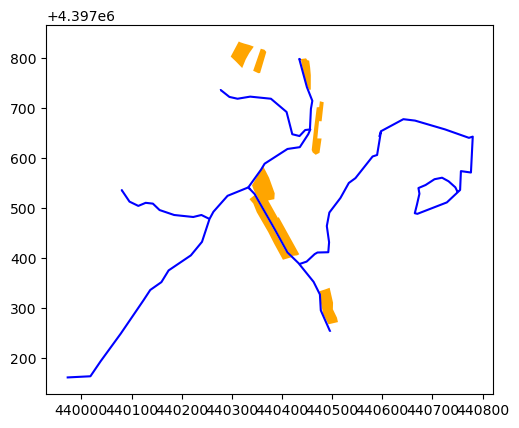

In [3]:
_, ax = plt.subplots()
all_road.plot(ax=ax, color='b')
all_land.plot(ax=ax, color='orange')
ax.set_aspect('equal')

<Axes: >

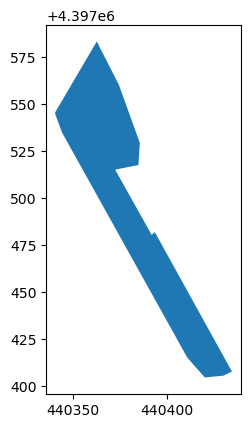

In [4]:
single_land = CPP_Planner_Kit.get_single_shp(all_land, 0)
single_land.plot()

split_polygon_by_largest_area： 开始进行田块分割，当前误差范围 tolerance = 0.05
Num of convex_hull:  9
Num of Polygon lines:  14
Not on Convex:  6


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


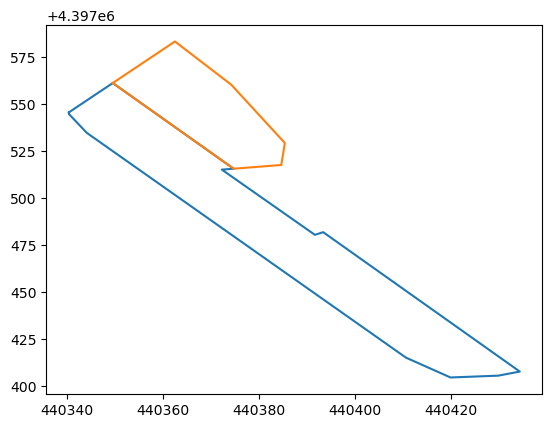

In [5]:
split_polygon = CPP_Planner_Kit.split_polygon_by_largest_area(single_land.geometry.iloc[0], tolerance=0.05)
_, ax = plt.subplots()
for polygon in split_polygon:
    ax.plot(*polygon.exterior.xy)


当前田块角度： -61.058869728464344


/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:1000: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)


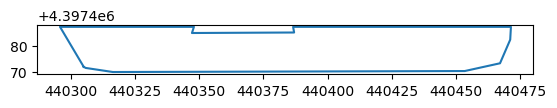

In [6]:
# 旋转
single_polygon = split_polygon[0]
single_polygon_angle = CPP_Planner_Kit.get_land_MABR_angle(single_polygon)
single_polygon = affinity.rotate(single_polygon, -single_polygon_angle, origin='centroid')
_, ax = plt.subplots()
ax.plot(*single_polygon.exterior.xy)
ax.set_aspect('equal')

In [7]:
# 进行基础的路径规划，此时不用地头
single_polygon_regen = gpd.GeoDataFrame(geometry=[single_polygon], crs=all_land.crs)
path, headland = CPP_Algorithms.scanline_algorithm_single_with_headland(single_polygon_regen, 1.45, False, 'none')

/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


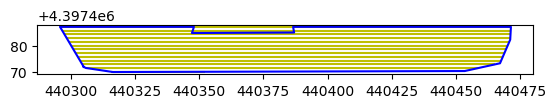

In [8]:
_, ax = plt.subplots()
path.plot(ax=ax, color='y')
ax.plot(*single_polygon.exterior.xy, color='b')

In [9]:
# 假定一个地头宽度
headland_width = 9

In [10]:
# 检查当前路径和地块边界的交点
# 左侧
path_left = path.geometry
intersect_points = []
for line in path_left:
    # print(line.coords[0][0])
    if line.coords[0][0] < line.coords[-1][0]:
        left_point, right_point = line.coords[0], line.coords[-1]
    else:
        left_point, right_point = line.coords[-1], line.coords[0]
    # 因为是左侧，仅保留左侧很小的一部分，用于检测相交的点
    # temp_detection_line = LineString((left_point, (left_point[0] + 1, left_point[1])))
    # intersect_points.append(temp_detection_line.intersection(single_polygon))
    intersect_points.append(left_point)
intersect_points

[(440315.8166841243, 4397470.128715448),
 (440306.1618653567, 4397471.578715448),
 (440304.5555067897, 4397473.028715448),
 (440303.6957144213, 4397474.478715449),
 (440302.8359220528, 4397475.928715449),
 (440301.9761296843, 4397477.378715449),
 (440301.1163373159, 4397478.828715449),
 (440300.2565449474, 4397480.278715449),
 (440299.39675257896, 4397481.72871545),
 (440298.5369602105, 4397483.17871545),
 (440297.67716784205, 4397484.62871545),
 (440296.81737547356, 4397486.07871545),
 (440295.9575831051, 4397487.52871545)]

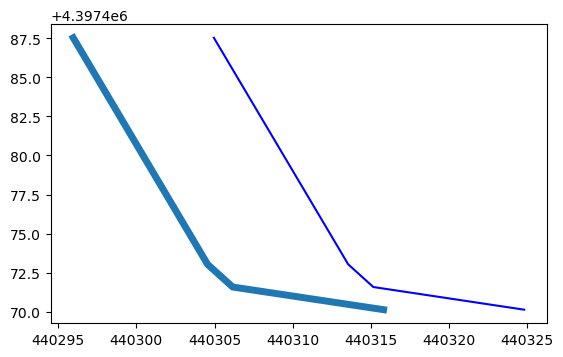

In [11]:
line = LineString(intersect_points)
headland_edge = affinity.translate(line, xoff=headland_width)
# 制作出地头
_, ax = plt.subplots()
ax.plot(*line.xy, linewidth=5)
ax.plot(*headland_edge.xy, color='b')
ax.set_aspect('equal')

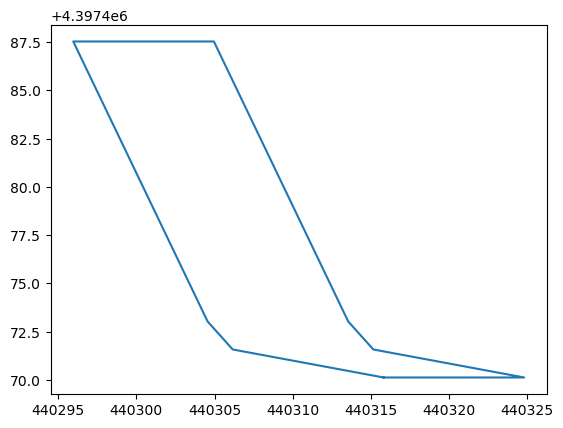

In [12]:
combined_polygon = list(line.coords)
combined_polygon += list(reversed(headland_edge.coords))
combined_polygon = Polygon(combined_polygon)
plt.plot(*combined_polygon.exterior.xy)

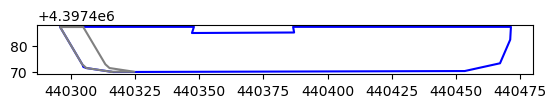

In [13]:
# 显示所有的结果
_, ax = plt.subplots()
ax.plot(*single_polygon.exterior.xy, color='b')
ax.plot(*combined_polygon.exterior.xy, color='gray')
ax.set_aspect('equal')

/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:77: RuntimeWarning: invalid value encountered in difference
  return lib.difference(a, b, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


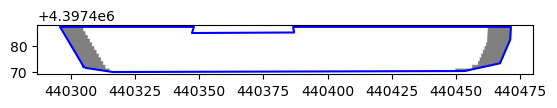

In [14]:
temp_path, temp_headland = CPP_Algorithms.scanline_algorithm_single_with_headland(single_polygon_regen, 1.45, False, 'both', headland_width)
_, ax = plt.subplots()
temp_headland.plot(ax=ax, color='gray')
ax.plot(*single_polygon.exterior.xy, color='b')

/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:881: RuntimeWarning: invalid value encountered in simplify_preserve_topology
  return lib.simplify_preserve_topology(geometry, tolerance, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


<Axes: >

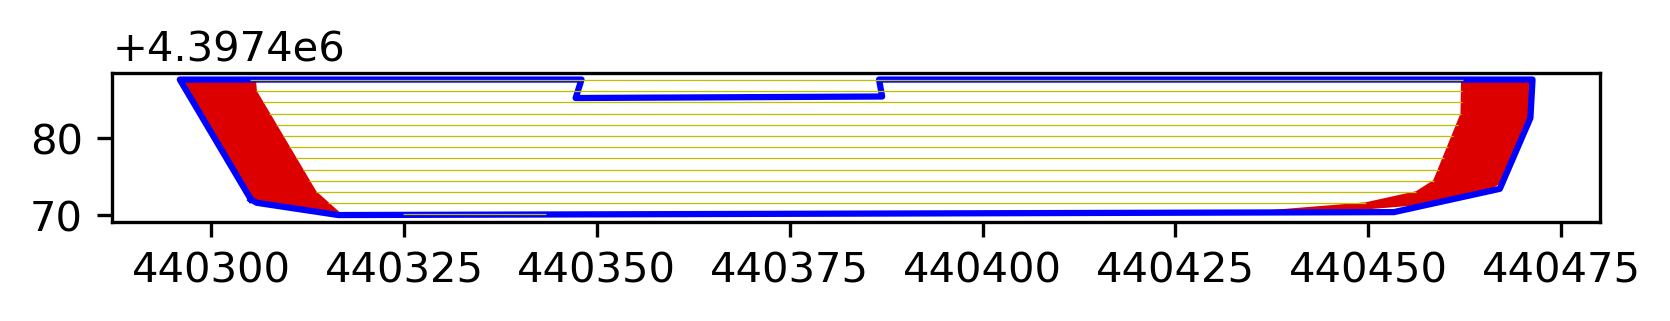

In [15]:
# 测试代码
temp_path_2, temp_headland_2 = CPP_Algorithms.scanline_algorithm_single_with_headland_2(
    single_polygon_regen, 1.45, False, 'both', headland_width
)
fig, ax = plt.subplots(dpi=300)
ax.plot(*single_polygon.exterior.xy, color='b')
temp_path_2.plot(ax=ax, color='y', linewidth=0.3)
temp_headland_2.plot(ax=ax, color='#DD0000')

/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:1000: RuntimeWarning: invalid value encountered in oriented_envelope
  return lib.oriented_envelope(geometry, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/constructive.py:881: RuntimeWarning: invalid value encountered in simplify_preserve_topology
  return lib.simplify_preserve_topology(geometry, tolerance, **kwargs)
/Users/outianyi/miniforge3/envs/pytorch_env/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


当前田块角度： -62.94942834767135


<Axes: >

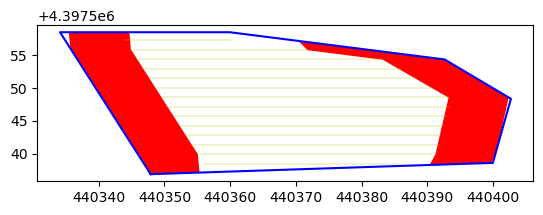

In [16]:
single_polygon_2 = split_polygon[1]
single_polygon_angle_2 = CPP_Planner_Kit.get_land_MABR_angle(single_polygon_2)
single_polygon_2 = affinity.rotate(single_polygon_2, -single_polygon_angle_2, origin='centroid')
single_polygon_regen_2 = gpd.GeoDataFrame(geometry=[single_polygon_2], crs=all_land.crs)
temp_path_3, temp_headland_3 = CPP_Algorithms.scanline_algorithm_single_with_headland_2(
    single_polygon_regen_2, 1.45, False, 'both', headland_width
)
fig, ax = plt.subplots()
ax.plot(*single_polygon_2.exterior.xy, color='b')
temp_path_3.plot(ax=ax, color='y', linewidth=0.3)
temp_headland_3.plot(ax=ax, color='red')

In [20]:
all_headland = []
for i in temp_headland_2.geometry[0].geoms:
    all_headland.append(i)
for i in temp_headland_3.geometry[0].geoms:
    all_headland.append(i)
all_headland

[<POLYGON ((440449.645 4397471.678, 440456.21 4397473.123, 440458.441 4397474...>,
 <POLYGON ((440304.714 4397472.761, 440296.704 4397486.27, 440296.577 4397487...>,
 <POLYGON ((440391.23 4397539.924, 440393.223 4397548.528, 440383.217 4397554...>,
 <POLYGON ((440335.452 4397558.482, 440344.671 4397558.482, 440344.901 439755...>]

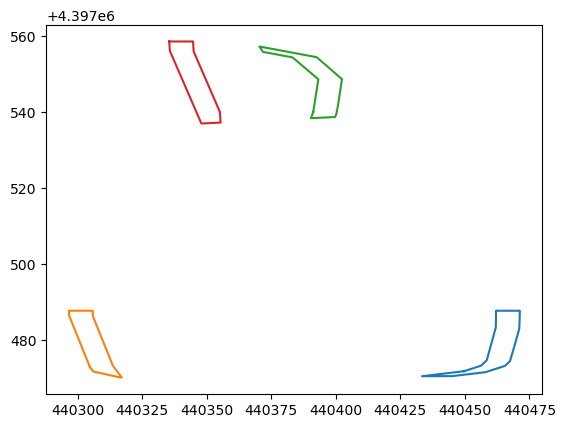

In [21]:
_, ax = plt.subplots()
for poly in all_headland:
    ax.plot(*poly.exterior.xy)